In [1]:
# Beamlet scripts
import glets.raytrace as rt
import glets.gbd as gf
import glets.utils as ut

# Utilities
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.ndimage import zoom

# poppy
import astropy.units as u
import poppy

# Simple profiling
import time

poppy.conf.use_numexpr = True
poppy.accel_math._USE_NUMEXPR

def compute_mean_std(data):
    return np.mean(data),np.std(data)

def kolphase(s):
    #phase=kolphaseClass(s)
    # Returns a random Kolmogorov phase screen of dimension s x s computed 
    # from the FT of random complex numbers with appropriate amplitudes. 
    # Screens are computed on a grid of size 2s, with a s x s piece cut out. 
    # This helps overcome the problem with this techniqe of under-representing 
    # tilt. Tandom tilts are also explicity added to give a reasonable 
    # approximation of the overall Kolmogorav structure function on all scales.
    ph=np.zeros([s,s,2]) #initialize phase variable
    [x,y]=np.meshgrid(range(-s,s),range(-s,s))
    r=np.sqrt(np.multiply(x,x)+np.multiply(y,y)) #make a radial ordinate
    
    f1=np.random.randn(2*s,2*s) #make two sets of gaussian random numbers
    f2=np.random.randn(2*s,2*s)
    
    f=f1+1j*f2 #turn the two random numbers into a complex random number
    ps=np.power(r,-11/6) #Kolomogorov power spectrum amplitude
    ps[s][s]=0; #setting the centr of the power spectrum (DC term) to zero
    
    scale=15.2 #this number makes the tilts work out 
    
    xt=np.random.randn(2)*(scale/s) #random amplitudes for tip and tilt to 
    yt=np.random.randn(2)*(scale/s) #mitigate power spectral rolloff at low frequencies 
    
    #This has Kolmogorov phases in real and imaginary parts
    sc= np.fft.fft2(np.fft.fftshift(np.multiply(np.multiply(np.abs(f),ps),np.exp(1j*np.angle(f))))) 
    
    #seperating the real and imaginary parts
    ph[:,:,0]=np.real(sc[0:s,0:s])+xt[0]*x[0:s,0:s]+yt[0]*y[0:s,0:s]
    ph[:,:,1]=np.real(sc[0:s,0:s])+xt[1]*x[0:s,0:s]+yt[1]*y[0:s,0:s]
    
    #make the mean phase zero
    ph[:,:,0]=ph[:,:,0]-np.mean(ph[:,:,0])
    ph[:,:,1]=ph[:,:,1]-np.mean(ph[:,:,1])
    
    #pick just one of the two phase screens for present purposes scale to 
    #something that will give reasonable ansewrs on a 1024 grid with 256 pupil
    ph=ph[:,:,1]*3
    
    return ph

numexpr sees numcores =  96
numexpr sees numthreads =  96
numexpr sees max threads =  96
numba threads =  16


In [2]:
# Set up Osys parameters for Hybrid and Fresnel System
nrays_across = 101
scale = 5e-1
detector_size = 0.04633 #5e-4
wlen = 2.1e-6
npix = 256
size = 6.5

/tmp/ipykernel_70044/3804271385.py:41: RuntimeWarning: divide by zero encountered in power
  ps=np.power(r,-11/6) #Kolomogorov power spectrum amplitude


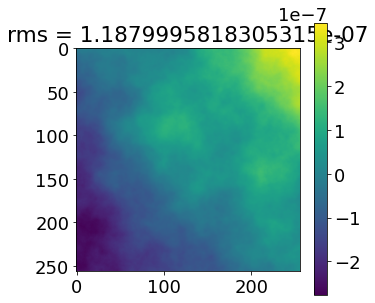

In [3]:
# Set up phase to be scaled
phase = kolphase(npix)*1e-8
plt.figure(figsize=[5,5])
plt.title('rms = {rms}'.format(rms=np.std(phase)))
plt.imshow(phase)
plt.colorbar()

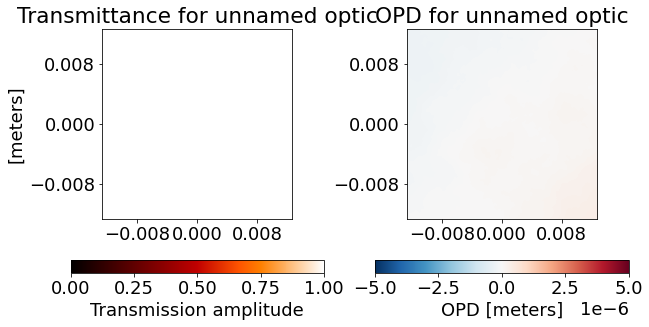

In [4]:
# Set up and propagate Fresnel
wf = poppy.FresnelWavefront(size/2*u.m,wavelength=wlen,npix=npix,oversample=8)
circ = poppy.CircularAperture(radius=size/2*u.m)
pwfe = poppy.ArrayOpticalElement(transmission=np.ones(phase.shape),opd=phase,pixelscale=wf.pixelscale)
# pwfe = poppy.ZernikeWFE(coefficients=[0,0,0,1*2.2e-6,0,0],radius=size/2*u.m)
thin = poppy.QuadraticLens(10*size*u.m)

# Grab applied WFE
opd_to_pass = ut.grab_center(pwfe.get_opd(wf),npix/2)

plt.figure(figsize=[10,5])
pwfe.display(what='both',opd_vmax=50e-7)
plt.show()

Text(0.5, 0.98, 'After propagating 0.254 m')

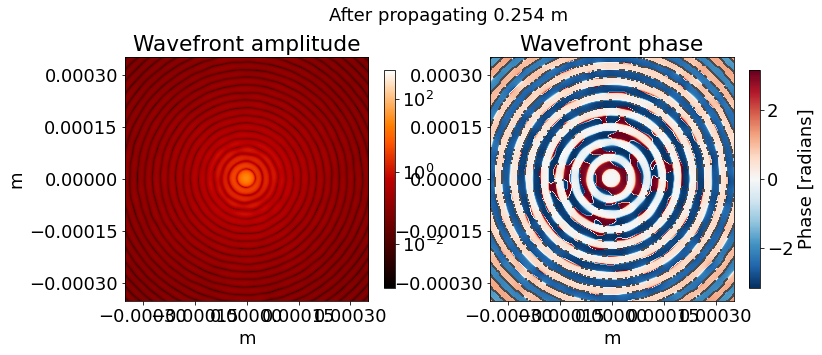

In [5]:
# Propagate
wf *= pwfe
wf *= circ
wf *= thin

z = 10*size*u.m # F/10 lens
wf.propagate_fresnel(z)

plt.figure(figsize=(12,5))
wf.display('both',colorbar=True,imagecrop=detector_size,scale='log')
plt.suptitle("After propagating {}".format(z), fontsize=18)

numbeamlets =  208
Computing Derivative for Pixelscale of =  0.0001221153846153846
pupil D =  0.00331304347826087
OF =  4.8697056863634245
time to assemble phase array =  76.85823480878025
profiling numexpr
Time to compute exponential  14.04640245437622  s


<Figure size 432x288 with 0 Axes>

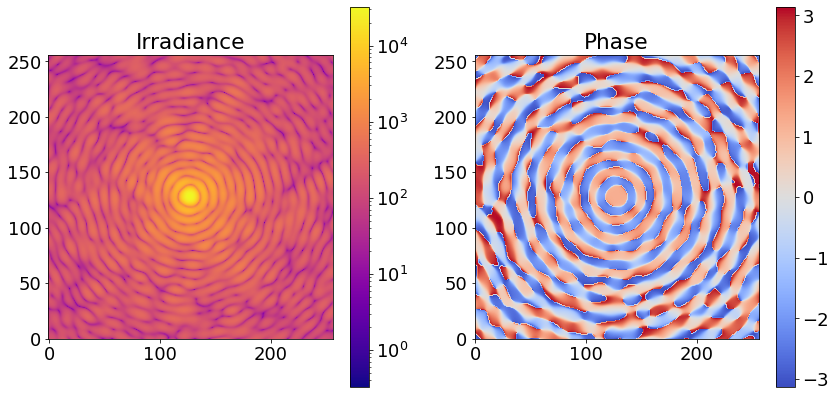

In [6]:
# Create square equally-spaced grid of rays
# rays = rt.makerays(size, nrays_across,circle=False)
rays = gf.ComputeRaysFromOF(1.8,size,50*wlen)
nrays_total = int((rays.shape[1]))
nrays_across = int(np.sqrt(nrays_total))

# Give rays some wavefront error
array_gbd = zoom(opd_to_pass,nrays_across/npix)
testrays = rt.ArbitraryWFE(nrays_across, size,rays,scale,array=array_gbd) # array assumes units of meters

# Set up optical system
lens = rt.ThinLens(10*size, nrays_total)
dist = rt.FreeSpace(10*size, nrays_total)
rayt = rt.matmultlist(lens, dist)
rayt = rt.matmultlist(dist,rayt)

# Select rays from circular aperture
raysincirc = testrays[:,np.sqrt(testrays[0,:]**2 + testrays[1,:]**2) <= size/2]
rtmincirc  = rayt[:,:,np.sqrt(testrays[0,:]**2 + testrays[1,:]**2) <= size/2]

# evaluate coherent sum of gaussian beamlets
efie_numerical = gf.eval_gausfield(raysincirc, rtmincirc, wlen, detector_size, npix, use_numexpr=True,return_rays=True)
efie_numerical = np.reshape(efie_numerical,[npix,npix])

ut.amp_phase_plot(efie_numerical,logintensity=True)

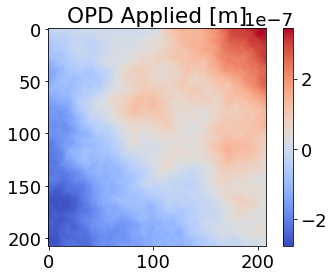

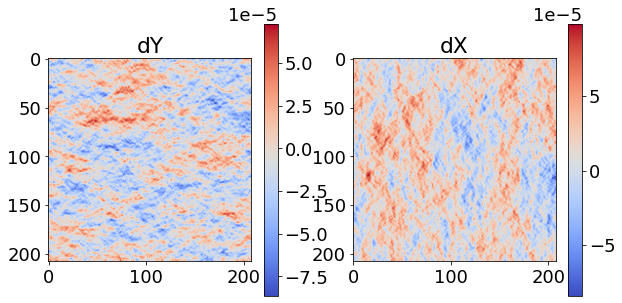

pixscacl =  0.0001221153846153846


In [7]:
# What phase was applied?
plt.figure()
plt.title('OPD Applied [m]')
plt.imshow(array_gbd)
plt.colorbar()
plt.show()

dy,dx = np.gradient(array_gbd,size/nrays_across)

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('dY')
plt.imshow(dy)
plt.colorbar()
plt.subplot(122)
plt.title('dX')
plt.imshow(dx)
plt.colorbar()
plt.show()
print('pixscacl = ',size/nrays_across)

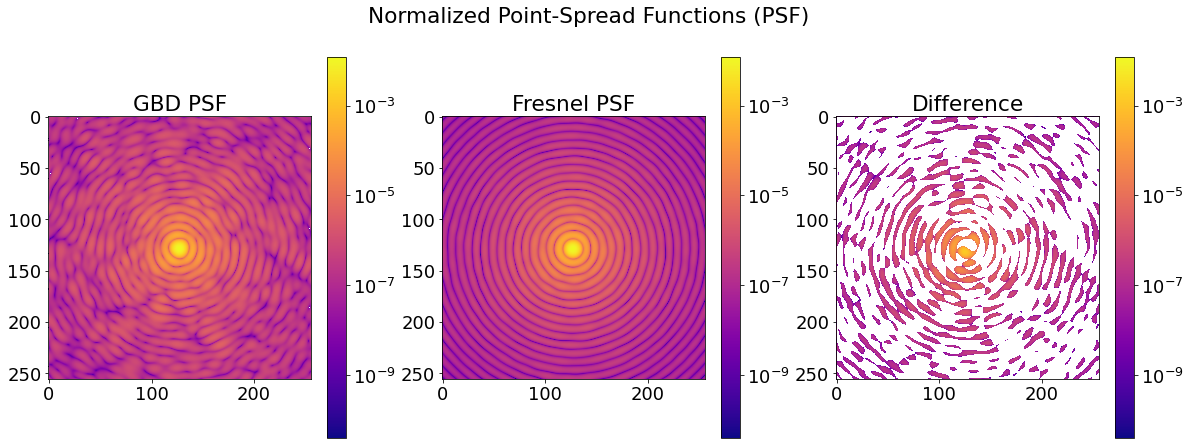

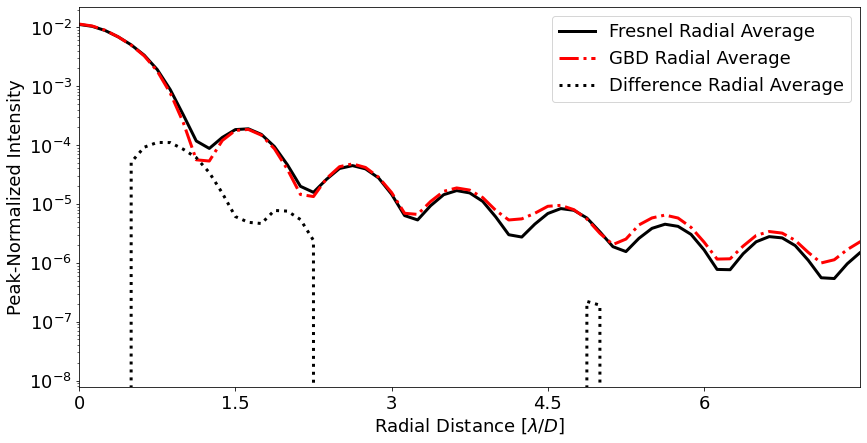

In [8]:
from scipy.ndimage import shift
from matplotlib.colors import LogNorm
# grab PSF center
efie_fresnel = ut.grab_center(wf.wavefront,npix/2)
vmin = None
vmax = None
norm = LogNorm()


def ComputeIntensity(array):
    return np.abs(array*np.conj(array))

def array2poppyhdul(array,pixscal):
    
    from astropy.io import fits
    phdu = fits.PrimaryHDU(array)
    hdul = fits.HDUList([phdu])
    hdul[0].header['PIXELSCL'] = pixscal
    
    return hdul

fnlpsf = ComputeIntensity(efie_fresnel)
fnlpsf /= np.sum(fnlpsf)
gbdpsf = shift(ComputeIntensity(efie_numerical),[0.5,0.5])
gbdpsf /= np.sum(gbdpsf)
difpsf = fnlpsf-gbdpsf

fnl_pro = poppy.radial_profile(array2poppyhdul(fnlpsf,2.74999666e-06))
gbd_pro = poppy.radial_profile(array2poppyhdul(gbdpsf,2.74999666e-06))
dif_pro = poppy.radial_profile(array2poppyhdul(difpsf,2.74999666e-06))



plt.figure(figsize=[20,7])
plt.set_cmap('plasma')
plt.suptitle('Normalized Point-Spread Functions (PSF)')
plt.subplot(131)
plt.title('GBD PSF')
plt.imshow(gbdpsf,norm=norm,vmin=vmin,vmax=vmax)
plt.colorbar()
plt.subplot(132)
plt.title('Fresnel PSF')
plt.imshow(fnlpsf,norm=norm,vmin=vmin,vmax=vmax)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
plt.imshow(difpsf,vmin=vmin,vmax=vmax,norm=norm)
plt.colorbar()
plt.show()

plt.figure(figsize=[14,7])
#plt.plot(fnl_hrz,label='Fresnel 0$^o$',color='black')
#plt.plot(fnl_m45,label='Fresnel 45$^o$',color='red')
#plt.plot(gbd_hrz,label='GBD 0$^o$',color='black',linestyle='solid',linewidth=4,alpha=.4)
#plt.plot(gbd_m45,label='GBD 45$^o$',color='red',linestyle='solid',linewidth=4,alpha=.4)
plt.plot(fnl_pro[1],label='Fresnel Radial Average',color='black',linewidth=3,linestyle='solid')
plt.plot(gbd_pro[1],label='GBD Radial Average',color='red',linewidth=3,linestyle='dashdot')
plt.plot(dif_pro[1],label='Difference Radial Average',color='black',linewidth=3,linestyle='dotted')
plt.yscale('log')
plt.xlim([0,60])
plt.xlabel('Radial Distance [$\lambda/D$]')
plt.ylabel('Peak-Normalized Intensity')
#plt.text(6,6,'$\sigma_d=${}'.format(np.std(ediff)))
plt.xticks(ticks=[0,12,24,36,48],labels=[0,1.5,3,4.5,6])
plt.legend()
plt.show()



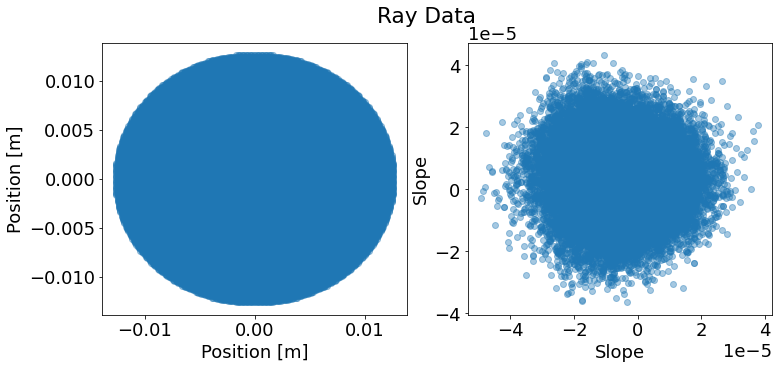

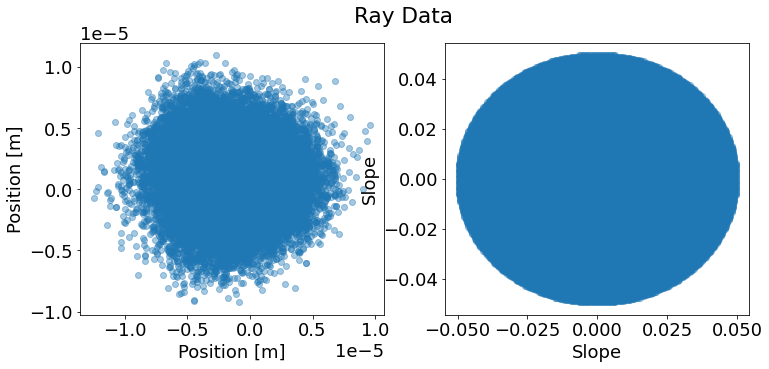

-0.0127


In [9]:
# Where did the rays intersect?

def ExamineRayset(rays):
    plt.figure(figsize=[12,5])
    plt.suptitle('Ray Data')
    plt.subplot(121)
    plt.scatter(rays[0,:],rays[1,:],alpha=0.4)
    plt.xlabel('Position [m]')
    plt.ylabel('Position [m]')
    plt.subplot(122)
    plt.scatter(rays[2,:],rays[3,:],alpha=0.4)
    plt.xlabel('Slope')
    plt.ylabel('Slope')
    plt.show()
    
ExamineRayset(raysincirc)
ExamineRayset(rt.matmultrays(rtmincirc,raysincirc))
print(testrays[0,0])

In [10]:
# Propagate PSF thorugh a Lyot Coronagraph Fresnel Model

In [11]:
def propagate_lyot(wfarray):
    
    osys = poppy.FresnelOpticalSystem(npix=256, beam_ratio=2)
    #osys.add_optic(poppy.ScalarTransmission())
    osys.add_optic(poppy.CircularAperture(radius=2.5e-5*7*u.m))
    osys.add_optic(poppy.InverseTransmission(poppy.CircularAperture(radius=2.5e-5*2*u.m)))
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.CircularAperture(radius=25.4e-3*0.9*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.ScalarTransmission(),distance=254e-3*u.m)
    psf = osys.calc_psf(wavelength=2.2e-6*u.m,inwave=wfarray)
    
    return psf

def propagate_NIRCam(wfarray):
    
    """
    The IWA and OWA using an EFL = 132.812m the sizes are
    IWA = 0.01544m
    OWA = 0.04633m
    """
    
    osys = poppy.FresnelOpticalSystem(npix=256, beam_ratio=2)
    #osys.add_optic(poppy.ScalarTransmission())
    
    
    # The Annular Occulting Mask
    osys.add_optic(poppy.CircularAperture(radius=2.5e-5*7*u.m))
    osys.add_optic(poppy.InverseTransmission(poppy.CircularAperture(radius=0.01544*u.m)))
    osys.add_optic((poppy.CircularAperture(radius=0.04633*u.m)))
    
    # The Unit magnification relay 10" lens - efl is arbitrary since it's 1-1
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    
    # The Lyot Stop
    osys.add_optic(poppy.CircularAperture(radius=25.4e-3*0.9*u.m),distance=254e-3*u.m)
    
    osys.add_optic(poppy.QuadraticLens(254e-3*u.m),distance=254e-3*u.m)
    osys.add_optic(poppy.ScalarTransmission(),distance=254e-3*u.m)
    psf = osys.calc_psf(wavelength=2.2e-6*u.m,inwave=wfarray)

<Figure size 432x288 with 0 Axes>

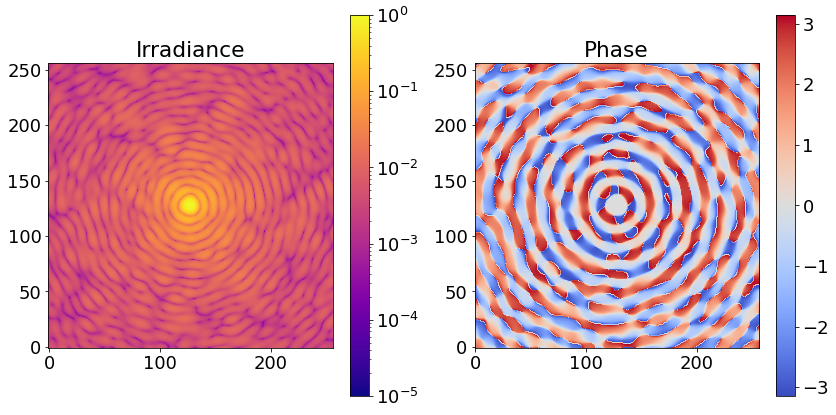

<Figure size 432x288 with 0 Axes>

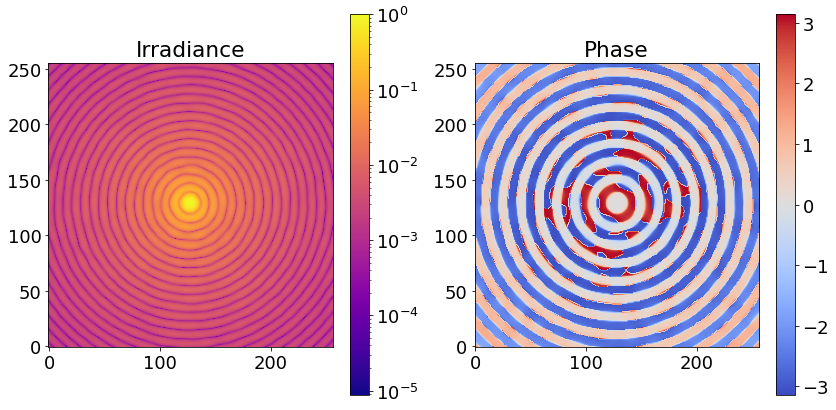

1.0.2.dev94+gbd13c76


/home/u6/jashcraft/.local/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


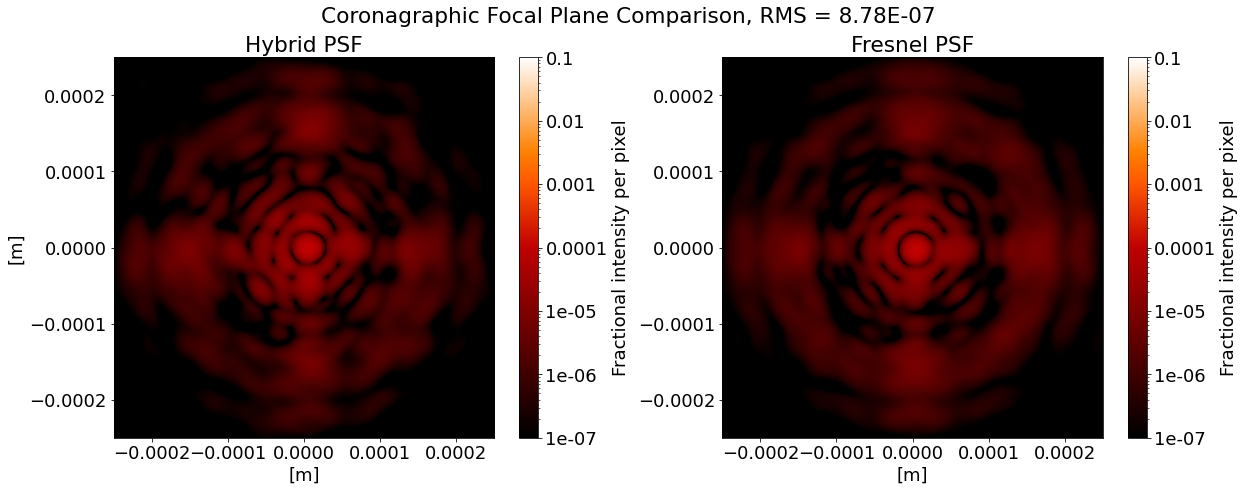

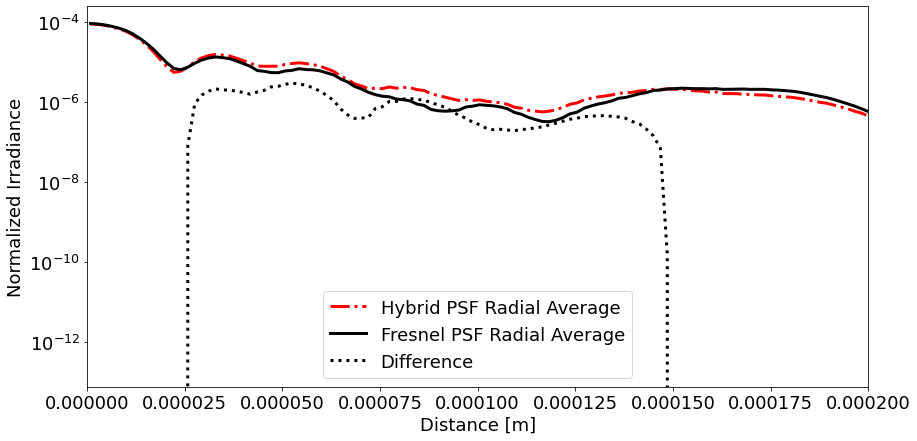

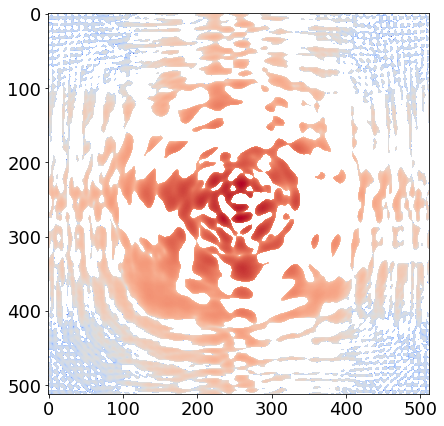

In [14]:
# make wavefronts


#efie_numerical /= np.sum(efie_numerical)
#efie_fresnel /= np.sum(efie_fresnel)

ut.amp_phase_plot(efie_numerical,logintensity=True)
ut.amp_phase_plot(efie_fresnel,logintensity=True)
print(poppy.__version__)

efie_numerical /= np.sum(efie_numerical)
efie_numerical /= np.max(efie_numerical)
efie_fresnel /= np.sum(efie_fresnel)
efie_fresnel /= np.max(efie_fresnel)

wfg = poppy.FresnelWavefront(beam_radius=5e-4/2*u.m,npix=256,oversample=2,wavelength=2.2e-6*u.m)
wff = poppy.FresnelWavefront(beam_radius=5e-4/2*u.m,npix=256,oversample=2,wavelength=2.2e-6*u.m)
wfg.wavefront = zoom(efie_numerical,2)
wff.wavefront = zoom(efie_fresnel,2)

psfg = propagate_lyot(wfg)
psff = propagate_lyot(wff)

# Compute Coronagraphic Profiles
gbd_pro = poppy.radial_profile(psfg)
fnl_pro = poppy.radial_profile(psff)
dif_pro = gbd_pro[1]-fnl_pro[1]

plt.figure(figsize=[20,7])
plt.suptitle('Coronagraphic Focal Plane Comparison, RMS = {:.2E}'.format(np.std(psfg[0].data-psff[0].data)))
plt.subplot(121)
poppy.display_psf(psfg,imagecrop=5e-4,title='Hybrid PSF')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.subplot(122)
poppy.display_psf(psff,imagecrop=5e-4,title='Fresnel PSF')
plt.xlabel('[m]')
plt.show()
plt.figure(figsize=[14,7])
plt.plot(gbd_pro[0],gbd_pro[1],label='Hybrid PSF Radial Average',color='red',linewidth=3,linestyle='dashdot')
plt.plot(gbd_pro[0],fnl_pro[1],label='Fresnel PSF Radial Average',color='black',linewidth=3,linestyle='solid')
plt.plot(gbd_pro[0],dif_pro,label='Difference',color='black',linewidth=3,linestyle='dotted')
plt.yscale('log')
plt.xlim([0,.0002])
plt.ylabel('Normalized Irradiance')
plt.xlabel('Distance [m]')
plt.legend()
plt.show()


from matplotlib.colors import LogNorm
plt.figure(figsize=[7,7])
plt.imshow((psfg[0].data-psff[0].data),norm=LogNorm())
plt.show()

NameError: name 'enumeric_pars' is not defined

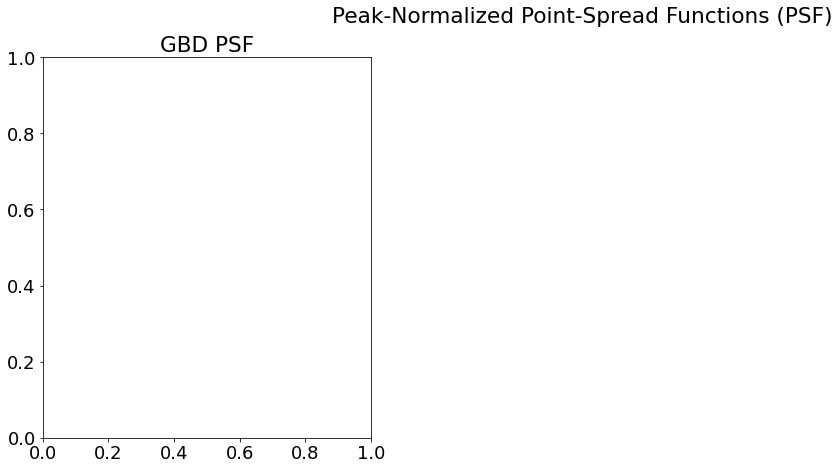

In [13]:
plt.figure(figsize=[20,7])
plt.set_cmap('plasma')
plt.suptitle('Peak-Normalized Point-Spread Functions (PSF)')
plt.subplot(131)
plt.title('GBD PSF')
plt.imshow(enumeric_pars,norm=LogNorm(),vmin=vmin,vmax=vmax)
plt.colorbar()
plt.subplot(132)
plt.title('Fresnel PSF')
plt.imshow(efresnel_pars,norm=LogNorm(),vmin=vmin,vmax=vmax)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
plt.imshow(ediff,vmin=vmin,vmax=vmax,norm=LogNorm())
plt.colorbar()
plt.show()